In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm, cholesky
from numpy.random import multivariate_normal

As both the primal and dual problems can be written as Quadratic Programs, we're going to reuse the functions from HW3 and apply them to our specific cases. 

In [ ]:
def phi(v ,A, b):
  """the barrier function"""
  if ((b-A.dot(v)).min() > 0):
    return - np.sum(np.log(b - A.dot(v)))
  else: return np.inf

def centering_step(Q, p, A, b, t, v0, eps, Niter=100000):
  v_seq = [v0]
  for i in range(Niter):
    v = v_seq[-1]
    grad_phi = A.T.dot(1 / (b - A @ v)) #gradient of the log barrier
    hess_phi = A.T @ np.diag(1 / (b - A @ v)**2) @ A #the hessian of the log barrier
    
    grad_v = t * (2 * Q @ v + p) + grad_phi 
    H = 2 * t * Q + hess_phi 
    L = np.linalg.cholesky(H)
    L_inv = np.linalg.inv(L)
    dum = L_inv @ grad_v #to avoid doing the same operation multiple times
    decrement = -L_inv.T @ dum
    lambda_squared = dum.dot(dum)

    if lambda_squared / 2 < eps: #stopping condition
      return v_seq
  #backtracking line search
    alpha = 1 
    back_test = lambda alpha: t * (alpha**2 * (decrement.T @ Q @ decrement)  + 0.75 * alpha * grad_v.dot(decrement))  + (phi(v + alpha * decrement, A, b) - phi(v, A, b) - 0.25 * alpha * grad_phi.dot(decrement))
    while ( back_test(alpha) >=0):
      alpha /= 2

    v_seq.append(v + alpha * decrement)

def barr_method(Q, p, A, b, v0, eps, t0=1, mu=2, Niter=10000, m=None):
  v_seq = [v0]
  nbr_iterations = [] #sequence of the number of inner iterations for each outer iteration
  t = t0
  if m==None: m = b.shape[0]
  for i in range(Niter):
    v = centering_step(Q, p, A, b, t, v0, eps)
    v0 = v[-1]
    v_seq.append(v0)
    nbr_iterations.append(len(v))
    if m/t < eps:
      return v_seq, nbr_iterations
    t *= mu
    


In [ ]:
def primal_func(w, z, C=1):
  return norm(w)**2 / 2 + C * np.sum(z)

def dual_func(u, X, y):
  yX = np.diag(y) @ X
  return norm(yX.T.dot(u)) ** 2 / 2 - np.sum(u)

In [ ]:
def primal_barrier(X, y, C, t0, w0, z0, eps, mu, Niter=10000):
  D = np.diag(y)
  n = w0.shape[0]
  m = z0.shape[0]
  v0 = np.concatenate((w0, z0))
  A1 = np.hstack((D.dot(X), np.eye(m)))
  A2 = np.hstack((np.zeros((m, n)), np.eye(m)))
  A = - np.vstack((A1, A2))
  b1 = np.ones(m)
  b2 = np.zeros(m)
  b = - np.concatenate((b1, b2))
  Q = np.zeros((n+m, n+m))
  Q[:n, :n] = np.eye(n) / 2
  p = C * np.concatenate((np.zeros(n), np.ones(m)))
  return barr_method(Q, p, A, b, v0, eps, t0, mu, Niter, m=2*m)

def dual_barrier(X, y, C, t0, u0, eps, mu, Niter=10e4):
  m = u0.shape[0]
  D = np.diag(y)
  Q = D @ X @ X.T @ D / 2
  p = -np.ones(m)
  A = np.vstack((np.eye(m), -np.eye(m)))
  b = C * np.concatenate((np.ones(m), np.zeros(m)))
  return barr_method(Q, p, A, b, u0, eps, t0, mu, Niter, m = 2*m)

In [ ]:
#Classification - two bivariate gaussian clouds
np.random.seed(8)
n = 3 #dim of the prob 2d + bias
k = 100 #number of examples
m = 2 * k
sigma = 0.1

center1 = np.array([3,3])
center2 = center1 + 1     
X1 = multivariate_normal(center1, sigma * np.eye(n-1), size=k)
X2 = multivariate_normal(center2, sigma * np.eye(n-1), size=k)
y1 = np.ones(k)
y2 = -np.ones(k)

X = np.hstack((np.vstack((X1, X2)), np.ones((m,1))))
y = np.concatenate((y1, y2))



w = randn(n)
yXw = y * X.dot(w)
z = np.maximum(0, 1 - yXw) + 0.1

#define a missclassification function:
def ratio_missclassifications(w):
  yXw = y * X.dot(w)
  return np.mean(np.sign(yXw) == -1)
  

In [ ]:
def plot_sol(X1, X2, w_primal, w_dual):
  xx1, yy1 = X1.T
  xx2, yy2 = X2.T
  plt.scatter(xx1, yy1, marker="x", color='r', label = '1st cloud')
  plt.scatter(xx2, yy2, marker="x", color='green', label = '2nd cloud')
  xx = np.linspace(min(xx1), max(xx2), 100)
  yy_primal =  -(w_primal[0] * xx + w_primal[2]) / w_primal[1]
  yy_dual =  -(w_dual[0] * xx + w_dual[2]) / w_dual[1]
  plt.plot(xx, yy_dual, label="dual solution hyperplan", color='blue', linestyle="dashed")
  plt.plot(xx, yy_primal, label="primal solution hyperplan", color='pink')
  miss_primal = ratio_missclassifications(w_primal)
  miss_dual = ratio_missclassifications(w_dual)
  plt.title("Classification - two bivariate gaussian clouds \n primal missclassifications ratio: {} \n dual missclassifications ratio:{}".format(miss_dual, miss_primal))
  plt.legend()




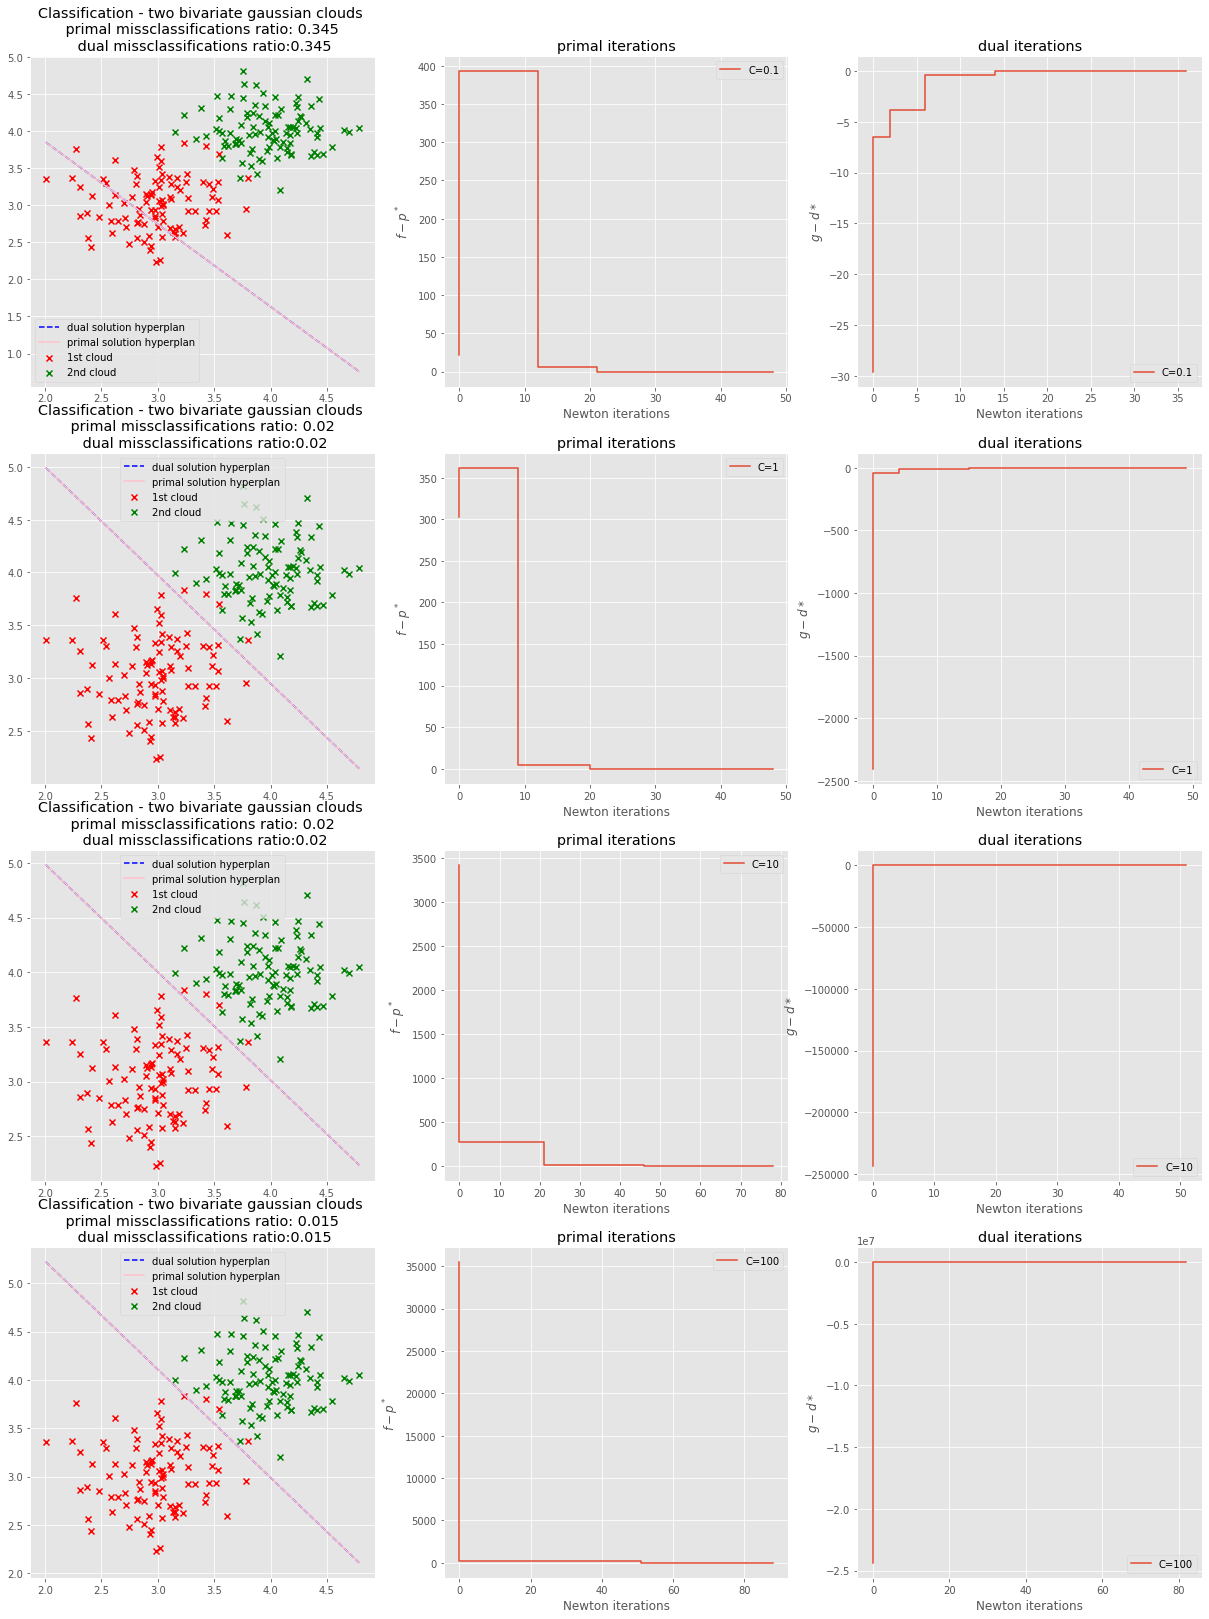

<Figure size 432x288 with 0 Axes>

In [ ]:
#trying out different values of C


C_range = [ 0.1, 1, 10, 100]
N = len(C_range)
count = 0
plt.figure(figsize=(7 * 3, 7 * N))
plt.style.use('ggplot')

for C in C_range:
  #primal iterations
  plt.subplot(N,3,count + 2)
  v_seq, nbr_iterations = primal_barrier(X, y, C, t0=1, w0=w, z0=z, eps=10e-4, mu=50)
  xaxis = np.concatenate((np.zeros(1), np.cumsum(nbr_iterations)))
  value_seq = np.array([primal_func(v[:n], v[n:], C) for v in v_seq]) 
  yaxis = value_seq - value_seq[-1]
  c = str(C)
  plt.step(xaxis, yaxis, label="C="+c)
  plt.xlabel("Newton iterations")
  plt.ylabel("$f-p^*$")
  plt.legend()
  plt.title("primal iterations")
  

  #dual iterations
  plt.subplot(N,3,count + 3)
  u0=C*np.ones(m) / 2
  u_seq, nbr_iterations = dual_barrier(X, y, C, t0=1, u0=u0, eps=10e-4, mu=20, Niter=1000)
  xaxis = np.concatenate((np.zeros(1), np.cumsum(nbr_iterations)))
  value_seq = np.array([-dual_func(u, X, y) for u in u_seq]) 
  yaxis = value_seq - value_seq[-1]
  c = str(C)
  plt.step(xaxis, yaxis, label="C="+c)
  plt.xlabel("Newton iterations")
  plt.ylabel("$g-d*$")
  plt.legend()
  plt.title("dual iterations")
  

  #
  plt.subplot(N,3,count + 1)
  v = v_seq[-1]
  w_primal = v[:n]
  
  u = u_seq[-1]
  w_dual = X.T @ np.diag(y) @ u
  plot_sol(X1, X2, w_primal, w_dual)
  count += 3


plt.show()

plt.clf()




In [ ]:
C=5

In [ ]:
u0=C*np.ones(m) / 2
dual_seq = dual_barrier(X, y, C, t0=1, u0=u0, eps=10e-4, mu=15, Niter=1000)
u = dual_seq[0][-1]
w_dual = X.T @ np.diag(y) @ u

In [ ]:
primal_seq = primal_barrier(X, y, C, t0=1, w0=w, z0=z, eps=10e-4, mu=15)
v = primal_seq[0][-1]
w_primal = v[:n]

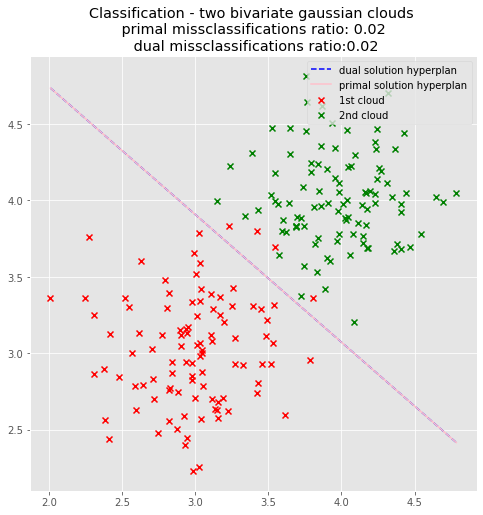

In [ ]:
plt.figure(figsize=(8,8))
plot_sol(X1, X2, w_dual, w_dual)
plt.show()